# Profiling skforecast

This document shows the profiling of the main classes, methods and functions available in skforecast. Understanding the bottlenecks will help to:

+ Use it more efficiently
+ Improve the code for future releases

## Libraries

In [1]:
# Libraries
# ==============================================================================
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

%load_ext pyinstrument

## Data

A time series of length 1000 with random values is created.

In [2]:
# Data
# ==============================================================================
np.random.seed(123)
n = 1_000
data = pd.Series(data = np.random.normal(size=n))

## Dummy regressor

To isolate the training process of the regressor from the other parts of the code, a dummy regressor class is created. This dummy regressor has a fit method that does nothing, and a predict method that returns a constant value.

In [3]:
class DummyRegressor(LinearRegression):
    """
    Dummy regressor with dummy fit and predict methods.
    """
    
    def fit(self, X, y):
        pass

    def predict(self, y):
        predictions = np.ones(shape = len(y))
        return predictions
        

## Profiling fit

In [4]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:58:43  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.004     CPU time: 0.004
/   _/                      v4.5.0

Program: /home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9019 --control=9017 --hb=9016 --Session.signature_scheme="hmac-sha256" --Session.key=b"4d9ad00e-f78d-41a8-b595-cfe0de6ac34c" --shell=9018 --transport="tcp" --iopub=9020 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-41411yEYXBXKWDdj.json

0.003 <module>  ../../../../../../tmp/ipykernel_5881/2958573061.py:1
`- 0.003 ForecasterAutoreg.fit  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:431
      [15 frames hidden]  skforecast, pandas
         0.001 ForecasterAutoreg._create_lags  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:248
         0.001 SingleBlockManager.internal_values  pandas/core/internals/managers.py:2011
         0.001 arithmetic_op  pandas/core/ops/array_ops.py:191

Almost all of the time spent by `fit` is required by the `create_train_X_y` method.

In [5]:
%%pyinstrument

forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:58:43  Samples:  91
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.153     CPU time: 0.279
/   _/                      v4.5.0

Program: /home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9019 --control=9017 --hb=9016 --Session.signature_scheme="hmac-sha256" --Session.key=b"4d9ad00e-f78d-41a8-b595-cfe0de6ac34c" --shell=9018 --transport="tcp" --iopub=9020 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-41411yEYXBXKWDdj.json

0.152 <module>  ../../../../../../tmp/ipykernel_5881/1359942394.py:1
`- 0.152 ForecasterAutoreg.fit  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:431
      [161 frames hidden]  skforecast, sklearn, <__array_functio...
         0.065 ndarray.partition  None

When training a forecaster with a real machine learning regressor, the time spent by `create_train_X_y` is negligible compared to the time needed by the `fit` method of the regressor. Therefore, improving the speed of `create_train_X_y` will not have much impact.

## Profiling create_train_X_y

Understand how the `create_train_X_y` method is influenced by the length of the series and the number of lags. 

In [6]:
# Profiling `create_train_X_y` for different length of series and number of lags
# ======================================================================================
series_length = np.linspace(1000, 1000000, num=5, dtype=int)
n_lags = [5, 10, 50, 100, 200]
results = {}

for lags in n_lags:
    execution_time = []
    forecaster = ForecasterAutoreg(
                     regressor = DummyRegressor(),
                     lags      = lags
                 )

    for n in series_length:
        y = pd.Series(data = np.random.normal(size=n))
        tic = time.perf_counter()
        _ = forecaster.create_train_X_y(y=y)
        toc = time.perf_counter()
        execution_time.append(toc-tic)

    results[lags] = execution_time

results = pd.DataFrame(
              data =  results,
              index = series_length
          )

results

,5,10,50,100,200
1000,0.001328,0.000788,0.000817,0.002116,0.003013
250750,0.008482,0.023412,0.126703,0.255135,0.508422
500500,0.015588,0.052422,0.255091,0.506566,0.998829
750250,0.024476,0.067499,0.383377,0.749951,1.481535
1000000,0.030307,0.091011,0.492627,0.991524,2.012482


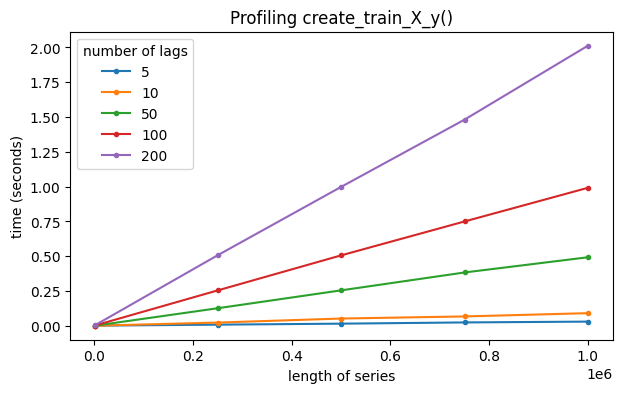

In [7]:
fig, ax = plt.subplots(figsize=(7, 4))
results.plot(ax=ax, marker='.')
ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');

## Profiling predict

In [8]:
forecaster = ForecasterAutoreg(
                 regressor = DummyRegressor(),
                 lags      = 24
             )

forecaster.fit(y=data)

In [9]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:58:53  Samples:  69
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.074     CPU time: 0.079
/   _/                      v4.5.0

Program: /home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9019 --control=9017 --hb=9016 --Session.signature_scheme="hmac-sha256" --Session.key=b"4d9ad00e-f78d-41a8-b595-cfe0de6ac34c" --shell=9018 --transport="tcp" --iopub=9020 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-41411yEYXBXKWDdj.json

0.073 <module>  ../../../../../../tmp/ipykernel_5881/3639615597.py:1
|- 0.069 ForecasterAutoreg.predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:566
|     [30 frames hidden]  skforecast, <__array_function__ inter...
|        0.068 ForecasterAutoreg._recursive_predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:519
|        |  0.028 implement_array_function  None
|        |- 0.010 DummyRegressor.predict  ../../../../../../tmp/ipykernel_5881/3778797810.py:9
|        |  `- 0.010 ones  numpy/core/numeric.py:150
|        |        [8 frames hidden]  numpy, <__array_function__ internals>...
`- 0.005 [self]  None

In [10]:
forecaster = ForecasterAutoreg(
                 regressor = HistGradientBoostingRegressor(max_iter=10, random_state=123),
                 lags      = 24
             )

forecaster.fit(y=data)

In [11]:
%%pyinstrument

_ = forecaster.predict(steps=1000)

_     ._   __/__   _ _  _  _ _/_   Recorded: 18:58:53  Samples:  504
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.506     CPU time: 1.921
/   _/                      v4.5.0

Program: /home/ubuntu/anaconda3/envs/skforecast_09_py11/lib/python3.11/site-packages/ipykernel_launcher.py --ip=127.0.0.1 --stdin=9019 --control=9017 --hb=9016 --Session.signature_scheme="hmac-sha256" --Session.key=b"4d9ad00e-f78d-41a8-b595-cfe0de6ac34c" --shell=9018 --transport="tcp" --iopub=9020 --f=/home/ubuntu/.local/share/jupyter/runtime/kernel-v2-41411yEYXBXKWDdj.json

0.505 <module>  ../../../../../../tmp/ipykernel_5881/3639615597.py:1
`- 0.505 ForecasterAutoreg.predict  skforecast/ForecasterAutoreg/ForecasterAutoreg.py:566
      [199 frames hidden]  skforecast, sklearn, <built-in>, <fro...

Inside the `predict` method, the `append` action is the most expensive but, similar to what happen with `fit`, it is negligible compared to the time need by the `predict` method of the regressor.